In [34]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [35]:
DATA_PATH = Path("../data/processed/2023_pace_laps_with_delta_phase_trackcluster.csv")


df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (21660, 48)


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,LapInStint,Compound_encoded,Driver_encoded,Team_encoded,TrackBaselineLapTime,LapDelta_seconds,MaxLapInRace,FuelProxy,RaceProgress,TrackCluster
0,0 days 01:07:10.728000,ALB,23,0 days 00:01:31.768000,3.0,1.0,NaN,NaN,0 days 00:00:18.588000,0 days 00:00:38.312000,...,1,2,0,9,90.130325,1.637675,58.0,0.948276,0.051724,3
1,0 days 01:08:42.319000,ALB,23,0 days 00:01:31.591000,4.0,1.0,NaN,NaN,0 days 00:00:18.657000,0 days 00:00:38.211000,...,2,2,0,9,90.130325,1.460675,58.0,0.931034,0.068966,3
2,0 days 01:10:13.741000,ALB,23,0 days 00:01:31.422000,5.0,1.0,NaN,NaN,0 days 00:00:18.605000,0 days 00:00:38.328000,...,3,2,0,9,90.130325,1.291675,58.0,0.913793,0.086207,3
3,0 days 01:11:45.232000,ALB,23,0 days 00:01:31.491000,6.0,1.0,NaN,NaN,0 days 00:00:18.696000,0 days 00:00:38.325000,...,4,2,0,9,90.130325,1.360675,58.0,0.896552,0.103448,3
4,0 days 01:13:16.670000,ALB,23,0 days 00:01:31.438000,7.0,1.0,NaN,NaN,0 days 00:00:18.537000,0 days 00:00:38.553000,...,5,2,0,9,90.130325,1.307675,58.0,0.879310,0.120690,3


In [36]:
df["TyreLifeSquared"] = df["TyreLife"] ** 2


In [37]:
"RaceName" in df.columns


True

In [38]:
df = pd.get_dummies(df, columns=["RaceName"], prefix="Track")



In [39]:
df["Driver_encoded"] = df["Driver"].astype("category").cat.codes
df["Team_encoded"] = df["Team"].astype("category").cat.codes


In [40]:
track_cols = [col for col in df.columns if col.startswith("Track_")]

for track_col in track_cols:
    df[f"{track_col}_TyreLife"] = df["TyreLife"] * df[track_col]
    df[f"{track_col}_TyreLifeSquared"] = df["TyreLifeSquared"] * df[track_col]


In [41]:
df["Compound_encoded"] = df["Compound"].astype("category").cat.codes


In [42]:
feature_cols = [
    "TyreLife",
    "TyreLifeSquared",
    "LapNumber",
    "Stint",
    "Compound_encoded",
    "Driver_encoded",
    "Team_encoded",
    "FuelProxy",
    "RaceProgress",
] + track_cols

interaction_cols = [col for col in df.columns if "_TyreLife" in col]
feature_cols += interaction_cols

X = df[feature_cols]
y = df["LapDelta_seconds"]

len(feature_cols)


78

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)

print("MAE:", mae)


MAE: 0.42108123900721844


In [44]:
joblib.dump(
    {"model": model},
    "../models/lap_delta_random_forest_trackaware_v2.pkl"
)


['../models/lap_delta_random_forest_trackaware_v2.pkl']

In [45]:
df.columns.tolist()


['Time',
 'Driver',
 'DriverNumber',
 'LapTime',
 'LapNumber',
 'Stint',
 'PitOutTime',
 'PitInTime',
 'Sector1Time',
 'Sector2Time',
 'Sector3Time',
 'Sector1SessionTime',
 'Sector2SessionTime',
 'Sector3SessionTime',
 'SpeedI1',
 'SpeedI2',
 'SpeedFL',
 'SpeedST',
 'IsPersonalBest',
 'Compound',
 'TyreLife',
 'FreshTyre',
 'Team',
 'LapStartTime',
 'LapStartDate',
 'TrackStatus',
 'Position',
 'Deleted',
 'DeletedReason',
 'FastF1Generated',
 'IsAccurate',
 'Year',
 'LapTime_seconds',
 'Sector1Time_seconds',
 'Sector2Time_seconds',
 'Sector3Time_seconds',
 'TyreLifeSquared',
 'LapInStint',
 'Compound_encoded',
 'Driver_encoded',
 'Team_encoded',
 'TrackBaselineLapTime',
 'LapDelta_seconds',
 'MaxLapInRace',
 'FuelProxy',
 'RaceProgress',
 'TrackCluster',
 'Track_Abu Dhabi Grand Prix',
 'Track_Australian Grand Prix',
 'Track_Austrian Grand Prix',
 'Track_Azerbaijan Grand Prix',
 'Track_Bahrain Grand Prix',
 'Track_Belgian Grand Prix',
 'Track_British Grand Prix',
 'Track_Canadian Gran

In [46]:
def get_track_slope(track_name):
    slopes = []
    for tyre_life in range(1, 25):
        row = {
            "TyreLife": tyre_life,
            "TyreLifeSquared": tyre_life ** 2,
            "LapNumber": 20,
            "Stint": 1,
            "Compound_encoded": 1,
            "Driver_encoded": 0,
            "Team_encoded": 0,
            "FuelProxy": 0.5,
            "RaceProgress": 0.3,
        }

        # activate track column
        for col in model.feature_names_in_:
            if col.startswith("Track_"):
                row[col] = 1 if col == f"Track_{track_name}" else 0

        # set missing columns to 0
        for col in model.feature_names_in_:
            if col not in row:
                row[col] = 0

        X_test = pd.DataFrame([row])[model.feature_names_in_]
        slopes.append(model.predict(X_test)[0])

    return slopes


bahrain_curve = get_track_slope("Bahrain Grand Prix")
monaco_curve = get_track_slope("Monaco Grand Prix")

print("Bahrain slope increase:", bahrain_curve[-1] - bahrain_curve[0])
print("Monaco slope increase:", monaco_curve[-1] - monaco_curve[0])


Bahrain slope increase: 0.8779152084590139
Monaco slope increase: 0.7271696267419601


In [47]:
# Identify base Track one-hot columns (not interaction ones)
track_cols = [
    col for col in df.columns
    if col.startswith("Track_") and "_TyreLife" not in col
]

track_slopes = {}

for track_col in track_cols:
    track_df = df[df[track_col] == 1]

    if len(track_df) > 50:  # ensure enough samples
        slope = np.polyfit(
            track_df["TyreLife"],
            track_df["LapDelta_seconds"],
            1
        )[0]

        track_slopes[track_col] = slope

# Normalize slopes
mean_slope = np.mean(list(track_slopes.values()))
track_degradation_factor = {
    track: slope / mean_slope
    for track, slope in track_slopes.items()
}

track_degradation_factor


{'Track_Abu Dhabi Grand Prix': 0.06599005974546747,
 'Track_Australian Grand Prix': 2.038068359937481,
 'Track_Austrian Grand Prix': -0.44447123130435784,
 'Track_Azerbaijan Grand Prix': 1.449405192381123,
 'Track_Bahrain Grand Prix': 0.28695588729777405,
 'Track_Belgian Grand Prix': -1.0470764149609744,
 'Track_British Grand Prix': 0.9704569516320202,
 'Track_Canadian Grand Prix': 0.2890160908089223,
 'Track_Dutch Grand Prix': 5.593723185232604,
 'Track_Hungarian Grand Prix': 0.005179387037632273,
 'Track_Italian Grand Prix': -0.43367155783309436,
 'Track_Japanese Grand Prix': -0.7239215179901051,
 'Track_Las Vegas Grand Prix': 1.9982156058711202,
 'Track_Mexico City Grand Prix': 1.7306085487915799,
 'Track_Miami Grand Prix': 0.47024037092533894,
 'Track_Monaco Grand Prix': 6.066181087590968,
 'Track_Pre-Season Testing': 0.9704569516320202,
 'Track_Qatar Grand Prix': -0.6150129719759067,
 'Track_Saudi Arabian Grand Prix': 1.8607373667620886,
 'Track_Singapore Grand Prix': 0.1995270718

In [48]:
df["LapTime"].head()

0    0 days 00:01:31.768000
1    0 days 00:01:31.591000
2    0 days 00:01:31.422000
3    0 days 00:01:31.491000
4    0 days 00:01:31.438000
Name: LapTime, dtype: str

In [49]:
# Convert LapTime column to timedelta explicitly
df["LapTime"] = pd.to_timedelta(df["LapTime"], errors="coerce")

# Now convert to seconds
df["LapTime_seconds"] = df["LapTime"].dt.total_seconds()

df[["LapTime", "LapTime_seconds"]].head()


,LapTime,LapTime_seconds
0,0 days 00:01:31.768000,91.768
1,0 days 00:01:31.591000,91.591
2,0 days 00:01:31.422000,91.422
3,0 days 00:01:31.491000,91.491
4,0 days 00:01:31.438000,91.438


In [50]:
df["LapTime_seconds"].describe()


count    21660.000000
mean        89.199763
std         10.685178
min         67.012000
25%         80.301000
50%         88.709500
75%         97.653500
max        148.490000
Name: LapTime_seconds, dtype: float64

In [51]:
df = df.sort_values(["Driver", "Stint", "LapNumber"])

df["StintBaseline"] = (
    df.groupby(["Driver", "Stint"])["LapTime_seconds"]
      .transform("first")
)

df["TrueDegradation_seconds"] = (
    df["LapTime_seconds"] - df["StintBaseline"]
)

df[["Driver", "Stint", "LapNumber", "TrueDegradation_seconds"]].head(15)


,Driver,Stint,LapNumber,TrueDegradation_seconds
2905,ALB,1.0,2.0,0.000
3750,ALB,1.0,2.0,-9.298
4647,ALB,1.0,2.0,5.093
5355,ALB,1.0,2.0,-14.724
6142,ALB,1.0,2.0,-30.098
7226,ALB,1.0,2.0,-1.548
8239,ALB,1.0,2.0,-22.198
9381,ALB,1.0,2.0,-22.661
11661,ALB,1.0,2.0,-24.176
12784,ALB,1.0,2.0,-14.551


In [52]:
# Identify base track columns
track_cols = [
    col for col in df.columns
    if col.startswith("Track_") and "_TyreLife" not in col
]

# Create readable TrackName column
df["TrackName"] = df[track_cols].idxmax(axis=1)

df["TrackName"].head()


2905    Track_Azerbaijan Grand Prix
3750       Track_Bahrain Grand Prix
4647       Track_Belgian Grand Prix
5355       Track_British Grand Prix
6142      Track_Canadian Grand Prix
Name: TrackName, dtype: str

In [53]:
# Sort properly
df = df.sort_values(["TrackName", "Driver", "Stint", "LapNumber"])

# Use FASTEST lap in stint as baseline
df["StintBaseline"] = (
    df.groupby(["TrackName", "Driver", "Stint"])["LapTime_seconds"]
      .transform("min")
)

# True tyre degradation
df["TrueDegradation_seconds"] = (
    df["LapTime_seconds"] - df["StintBaseline"]
)

df[["TrackName", "Driver", "Stint", "LapNumber", "TrueDegradation_seconds"]].head(20)


,TrackName,Driver,Stint,LapNumber,TrueDegradation_seconds
0,Track_Abu Dhabi Grand Prix,ALB,1.0,3.0,0.346
1,Track_Abu Dhabi Grand Prix,ALB,1.0,4.0,0.169
2,Track_Abu Dhabi Grand Prix,ALB,1.0,5.0,0.000
3,Track_Abu Dhabi Grand Prix,ALB,1.0,6.0,0.069
4,Track_Abu Dhabi Grand Prix,ALB,1.0,7.0,0.016
5,Track_Abu Dhabi Grand Prix,ALB,1.0,8.0,0.158
6,Track_Abu Dhabi Grand Prix,ALB,1.0,9.0,0.222
7,Track_Abu Dhabi Grand Prix,ALB,1.0,10.0,0.556
8,Track_Abu Dhabi Grand Prix,ALB,1.0,11.0,0.540
9,Track_Abu Dhabi Grand Prix,ALB,1.0,12.0,0.536


In [54]:
df["TrueDegradation_seconds"].describe()


count    21660.000000
mean         1.135242
std          2.565478
min          0.000000
25%          0.330000
50%          0.674000
75%          1.210000
max         65.730000
Name: TrueDegradation_seconds, dtype: float64

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X = df[feature_cols]
y = df["TrueDegradation_seconds"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)

print("MAE:", mae)


MAE: 0.4278217136041861


In [56]:
def get_track_slope(track_col_name):

    slopes = []

    for tyre_life in range(1, 25):

        row = {
            "TyreLife": tyre_life,
            "TyreLifeSquared": tyre_life ** 2,
            "LapNumber": 20,
            "Stint": 1,
            "Compound_encoded": 1,
            "Driver_encoded": 0,
            "Team_encoded": 0,
            "FuelProxy": 0.5,
            "RaceProgress": 0.3,
        }

        # Activate correct track
        for col in model.feature_names_in_:
            if col.startswith("Track_") and "_TyreLife" not in col:
                row[col] = 1 if col == track_col_name else 0

        # Fill missing columns with 0
        for col in model.feature_names_in_:
            if col not in row:
                row[col] = 0

        X_test = pd.DataFrame([row])[model.feature_names_in_]
        slopes.append(model.predict(X_test)[0])

    return slopes


bahrain_curve = get_track_slope("Track_Bahrain Grand Prix")
monaco_curve = get_track_slope("Track_Monaco Grand Prix")

print("Bahrain slope increase:", bahrain_curve[-1] - bahrain_curve[0])
print("Monaco slope increase:", monaco_curve[-1] - monaco_curve[0])


Bahrain slope increase: 0.7170199999999993
Monaco slope increase: 0.2553133333333323


In [57]:
model.feature_names_in_


array(['TyreLife', 'TyreLifeSquared', 'LapNumber', 'Stint',
       'Compound_encoded', 'Driver_encoded', 'Team_encoded', 'FuelProxy',
       'RaceProgress', 'Track_Abu Dhabi Grand Prix',
       'Track_Australian Grand Prix', 'Track_Austrian Grand Prix',
       'Track_Azerbaijan Grand Prix', 'Track_Bahrain Grand Prix',
       'Track_Belgian Grand Prix', 'Track_British Grand Prix',
       'Track_Canadian Grand Prix', 'Track_Dutch Grand Prix',
       'Track_Hungarian Grand Prix', 'Track_Italian Grand Prix',
       'Track_Japanese Grand Prix', 'Track_Las Vegas Grand Prix',
       'Track_Mexico City Grand Prix', 'Track_Miami Grand Prix',
       'Track_Monaco Grand Prix', 'Track_Pre-Season Testing',
       'Track_Qatar Grand Prix', 'Track_Saudi Arabian Grand Prix',
       'Track_Singapore Grand Prix', 'Track_Spanish Grand Prix',
       'Track_São Paulo Grand Prix', 'Track_United States Grand Prix',
       'Track_Abu Dhabi Grand Prix_TyreLife',
       'Track_Abu Dhabi Grand Prix_TyreLifeSquar

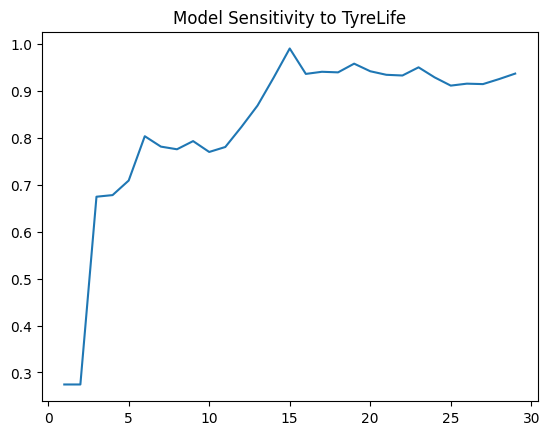

In [58]:
FEATURES = list(model.feature_names_in_)

test_df = pd.DataFrame(columns=FEATURES)

for tyre_life in range(1, 30):

    row = {col: 0 for col in FEATURES}

    if "TyreLife" in FEATURES:
        row["TyreLife"] = tyre_life

    if "TyreLifeSquared" in FEATURES:
        row["TyreLifeSquared"] = tyre_life ** 2

    if "LapNumber" in FEATURES:
        row["LapNumber"] = 20

    if "Stint" in FEATURES:
        row["Stint"] = 1

    if "Compound_encoded" in FEATURES:
        row["Compound_encoded"] = 1

    if "FuelProxy" in FEATURES:
        row["FuelProxy"] = 0.7

    if "RaceProgress" in FEATURES:
        row["RaceProgress"] = 0.3

    # Activate Bahrain track
    for col in FEATURES:
        if col == "Track_Bahrain Grand Prix":
            row[col] = 1

    test_df.loc[len(test_df)] = row

preds = model.predict(test_df)

import matplotlib.pyplot as plt
plt.plot(range(1, 30), preds)
plt.title("Model Sensitivity to TyreLife")
plt.show()


In [59]:
y = df["TrueDegradation_seconds"]


In [60]:
model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)

print("MAE:", mae)


MAE: 0.4278217136041861


In [61]:
joblib.dump(
    {"model": model},
    "../models/lap_delta_random_forest_trackaware_v3.pkl"
)


['../models/lap_delta_random_forest_trackaware_v3.pkl']

In [62]:
def test_track(track_name):
    rows = []
    for tl in range(1, 25):
        row = {col: 0 for col in model.feature_names_in_}

        row["TyreLife"] = tl
        row["TyreLifeSquared"] = tl**2
        row["LapInStint"] = tl
        row["LapNumber"] = tl
        row["Stint"] = 1
        row["Compound_encoded"] = 1
        row["Driver_encoded"] = 0
        row["Team_encoded"] = 0
        row["FuelProxy"] = 0.5
        row["RaceProgress"] = 0.5

        base = f"Track_{track_name}"
        inter1 = f"{base}_TyreLife"
        inter2 = f"{base}_TyreLifeSquared"

        if base in row:
            row[base] = 1
        if inter1 in row:
            row[inter1] = tl
        if inter2 in row:
            row[inter2] = tl**2

        rows.append(model.predict(pd.DataFrame([row]))[0])

    return rows


In [63]:
model.feature_names_in_

array(['TyreLife', 'TyreLifeSquared', 'LapNumber', 'Stint',
       'Compound_encoded', 'Driver_encoded', 'Team_encoded', 'FuelProxy',
       'RaceProgress', 'Track_Abu Dhabi Grand Prix',
       'Track_Australian Grand Prix', 'Track_Austrian Grand Prix',
       'Track_Azerbaijan Grand Prix', 'Track_Bahrain Grand Prix',
       'Track_Belgian Grand Prix', 'Track_British Grand Prix',
       'Track_Canadian Grand Prix', 'Track_Dutch Grand Prix',
       'Track_Hungarian Grand Prix', 'Track_Italian Grand Prix',
       'Track_Japanese Grand Prix', 'Track_Las Vegas Grand Prix',
       'Track_Mexico City Grand Prix', 'Track_Miami Grand Prix',
       'Track_Monaco Grand Prix', 'Track_Pre-Season Testing',
       'Track_Qatar Grand Prix', 'Track_Saudi Arabian Grand Prix',
       'Track_Singapore Grand Prix', 'Track_Spanish Grand Prix',
       'Track_São Paulo Grand Prix', 'Track_United States Grand Prix',
       'Track_Abu Dhabi Grand Prix_TyreLife',
       'Track_Abu Dhabi Grand Prix_TyreLifeSquar

In [64]:
# Inspect magnitude of predicted degradation for Bahrain

bahrain = test_track("Bahrain Grand Prix")

print("First few:", bahrain[:5])
print("Last few:", bahrain[-5:])
print("Total increase:", bahrain[-1] - bahrain[0])


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- LapInStint


In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib

driver_encoder = LabelEncoder()
team_encoder = LabelEncoder()

driver_encoder.fit(df["Driver"])
team_encoder.fit(df["Team"])

print(driver_encoder.classes_)
print(team_encoder.classes_)


NameError: name 'df' is not defined

In [ ]:
print("df" in globals())


True


In [ ]:
df.shape

(21660, 119)